In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from src.score import *
import re

import generate_data as gd

In [2]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [3]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

def create_predictions(model, dg):
    """Create non-iterative predictions"""
    preds_un = xr.DataArray(
        model.predict(dg),
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': dg.data.isel(level=dg.output_idxs).level,
                'level_names': dg.data.isel(level=dg.output_idxs).level_names
               },
    )
    # Unnormalize
    preds = (preds_un * dg.std.isel(level=dg.output_idxs).values +
             dg.mean.isel(level=dg.output_idxs).values)
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values])); unique_vars

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        #print(v, idxs)
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da.drop('level')
        das.append({v: da})
    return preds_un, xr.merge(das, compat = 'override').drop('level')

In [4]:
def predictions(var_name, valid):
    dg_train, dg_valid, dg_test = gd.create_data(var_name)

    if var_name == 'specific_humidity':
        cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 4))
    elif var_name == 'pot_vort':
        cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 4))
    elif var_name == 'const':
        cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 5))
    elif var_name == 'orig':
        cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2))
    else:
        cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 3))

    cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

    cnn.load_weights('/rds/general/user/mc4117/home/WeatherBench/saved_models/72_gpu_annual' + str(var_name) + '.h5')

    number_of_forecasts = 1

    pred_ensemble=np.ndarray(shape=(2, 17448, 32, 64, number_of_forecasts),dtype=np.float32)
    print(pred_ensemble.shape)
    forecast_counter=np.zeros(number_of_forecasts,dtype=int)

    for j in range(number_of_forecasts):
        print(j)
        preds, output = create_predictions(cnn, dg_test)
        pred2 = np.asarray(output.to_array(), dtype=np.float32).squeeze()
        pred_ensemble[:,:,:,:,j]=pred2
        forecast_counter[j]=j+1
        filename2 = '/rds/general/user/mc4117/ephemeral/saved_pred/72_gpu_annual' + str(var_name)
        np.save(filename2 + '.npy', pred_ensemble)
        


    return preds, compute_weighted_rmse(output, valid).compute()

In [5]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])


In [6]:
preds_orig, rmse = predictions('orig', valid)
rmse

Loading data into RAM
Loading data into RAM
Loading data into RAM
(2, 17448, 32, 64, 1)
0


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 706.9
    t        float64 3.222

In [7]:
preds_sh, rmse_sh = predictions('specific_humidity', valid)
rmse_sh

Loading data into RAM
Loading data into RAM
Loading data into RAM
(2, 17448, 32, 64, 1)
0


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 718.3
    t        float64 3.236

In [8]:
preds_pv, rmse_pv = predictions('pot_vort', valid)
rmse_pv

Loading data into RAM
Loading data into RAM
Loading data into RAM
(2, 17448, 32, 64, 1)
0


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 714.3
    t        float64 3.225

In [9]:
preds_const, rmse_const = predictions('const', valid)
rmse_const

Loading data into RAM
Loading data into RAM
Loading data into RAM
(2, 17448, 32, 64, 1)
0


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 713.4
    t        float64 3.173

In [10]:
preds_2mt, rmse_2mt = predictions('2m temp', valid)
rmse_2mt

Loading data into RAM
Loading data into RAM
Loading data into RAM
(2, 17448, 32, 64, 1)
0


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 708.3
    t        float64 3.188

In [11]:
preds_sr, rmse_sr = predictions('solar rad', valid)
rmse_sr

Loading data into RAM
Loading data into RAM
Loading data into RAM
(2, 17448, 32, 64, 1)
0


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 709.0
    t        float64 3.222

In [12]:
stack_out = np.stack([preds_orig, preds_sh, preds_pv, preds_const, 
                      preds_2mt,  preds_sr])  

In [13]:
dg_train, dg_valid, dg_test = gd.create_data('orig')
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))

Loading data into RAM
Loading data into RAM
Loading data into RAM


In [14]:
stack_out.shape

(6, 17448, 32, 64, 2)

In [15]:
stack_test_list = []

for i in range(6):
    stack_test_list.append(stack_out[i])

In [16]:
print(stack_test_list[0].shape)
print(y1.shape)

(17448, 32, 64, 2)
(17448, 32, 64, 2)


In [17]:
from tensorflow.keras.layers import concatenate

def my_init(shape, dtype=None):
    print(shape)
    return tf.ones(shape, dtype=dtype)/6

def build_stack_model(input_shape, stack_list):
    # concatenate merge output from each model
    input_list = [Input(shape=input_shape) for i in range(len(stack_list))]
    merge = concatenate(input_list)
    hidden = Dense(6, activation='relu', kernel_initializer = my_init, bias_initializer = tf.zeros)(merge)
    #hidden = Dense(64, activation='relu')(hidden)
    output = Dense(2)(hidden)
    return keras.models.Model(input_list, output)

In [18]:
ensemble_model = build_stack_model((32, 64, 2), stack_test_list)

ensemble_model.compile(keras.optimizers.Adam(1e-4), 'mse')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=5,
                        verbose=1, 
                        mode='auto'
                    )

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience=2,
            factor=0.2,
            verbose=1)  

ensemble_model.fit(x = stack_test_list, y = y1, epochs = 200, validation_split = 0.2, shuffle = True
                  , callbacks = [early_stopping_callback, reduce_lr_callback
                    ]) #, callbacks = [callback])

[12, 6]
Train on 13958 samples, validate on 3490 samples
Epoch 1/200
13958/13958 [==============================] - 23s 2ms/sample - loss: 0.6860 - val_loss: 0.5445
Epoch 2/200
13958/13958 [==============================] - 20s 1ms/sample - loss: 0.5227 - val_loss: 0.5069
Epoch 3/200
13958/13958 [==============================] - 21s 2ms/sample - loss: 0.4931 - val_loss: 0.4795
Epoch 4/200
13958/13958 [==============================] - 21s 1ms/sample - loss: 0.4666 - val_loss: 0.4533
Epoch 5/200
13958/13958 [==============================] - 21s 1ms/sample - loss: 0.4412 - val_loss: 0.4282
Epoch 6/200
13958/13958 [==============================] - 22s 2ms/sample - loss: 0.4170 - val_loss: 0.4041
Epoch 7/200
13958/13958 [==============================] - 21s 2ms/sample - loss: 0.3938 - val_loss: 0.3812
Epoch 8/200
13958/13958 [==============================] - 20s 1ms/sample - loss: 0.3716 - val_loss: 0.3593
Epoch 9/200
13958/13958 [==============================] - 19s 1ms/sample - los

In [19]:
    fc = ensemble_model.predict(stack_test_list)
    preds_un = xr.DataArray(
        fc,
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg_test.valid_time, 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                'level': dg_test.data.isel(level=dg_test.output_idxs).level,
                'level_names': dg_test.data.isel(level=dg_test.output_idxs).level_names
               },
    )
    # Unnormalize
    preds = (preds_un * dg_test.std.isel(level=dg_test.output_idxs).values +
             dg_test.mean.isel(level=dg_test.output_idxs).values)
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values])); unique_vars

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        #print(v, idxs)
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da.drop('level')
        das.append({v: da})
    fc_unnorm = xr.merge(das, compat = 'override').drop('level')

In [20]:

real_unnorm =y1* dg_test.std.isel(level=[0,1]).values+dg_test.mean.isel(level=[0,1]).values

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [21]:
compute_weighted_rmse(fc_unnorm, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 693.6
    t        float64 3.109

In [22]:
stack_total = sum(stack_test_list)/len(stack_test_list)

In [23]:
    preds_total_un = xr.DataArray(
        stack_total,
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg_test.valid_time, 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                'level': dg_test.data.isel(level=dg_test.output_idxs).level,
                'level_names': dg_test.data.isel(level=dg_test.output_idxs).level_names
               },
    )
    # Unnormalize
    preds_total = (preds_total_un * dg_test.std.isel(level=dg_test.output_idxs).values +
             dg_test.mean.isel(level=dg_test.output_idxs).values)
    unique_vars = list(set([l.split('_')[0] for l in preds_total.level_names.values])); unique_vars

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds_total.level_names.values) if vv.split('_')[0] in v]
        #print(v, idxs)
        da = preds_total.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da.drop('level')
        das.append({v: da})
    fc_unnorm_total = xr.merge(das, compat = 'override').drop('level')

In [24]:
compute_weighted_rmse(fc_unnorm_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 693.7
    t        float64 3.126

In [38]:
unnorm_pred_list = []

var_list = [preds_orig, preds_sh, preds_pv, preds_const, preds_2mt, preds_sr]

for var in var_list:
    
    preds_un = xr.DataArray(
        var,
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg_test.valid_time, 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                'level': dg_test.data.isel(level=dg_test.output_idxs).level,
                'level_names': dg_test.data.isel(level=dg_test.output_idxs).level_names
               },
    )
    # Unnormalize
    preds = (preds_un * dg_test.std.isel(level=dg_test.output_idxs).values +
             dg_test.mean.isel(level=dg_test.output_idxs).values)
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values])); unique_vars

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        #print(v, idxs)
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da.drop('level')
        das.append({v: da})
    fc_unnorm = xr.merge(das, compat = 'override').drop('level')

    unnorm_pred_list.append(fc_unnorm)

In [42]:
stack_mean = unnorm_pred_list[0].copy()

rmse_list = []

rmse_list.append(compute_weighted_rmse(stack_mean, real_ds).compute())
for i in range(1, len(unnorm_pred_list)):
    stack_mean += unnorm_pred_list[i].copy()
    rmse_list.append(compute_weighted_rmse(stack_mean/(i+1), real_ds).compute()) 

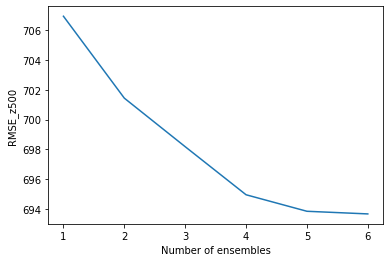

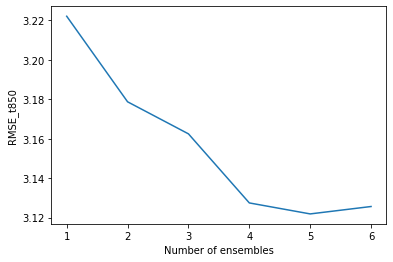

In [52]:
import pylab as plt

# effect of doing ensembles
plt.plot([i +1 for i in range(len(rmse_list))], [rmse_list[i].z for i in range(len(rmse_list))])
plt.xlabel('Number of ensembles')
plt.ylabel('RMSE_z500')
plt.show()

plt.plot([i +1 for i in range(len(rmse_list))], [rmse_list[i].t for i in range(len(rmse_list))])
plt.xlabel('Number of ensembles')
plt.ylabel('RMSE_t850')
plt.show()

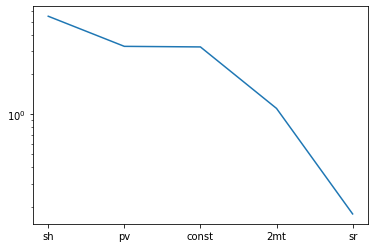

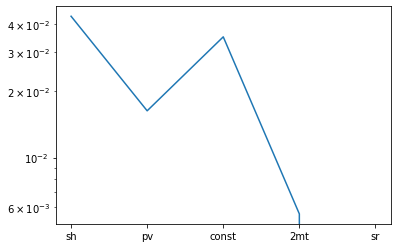

In [53]:
rmse_z = [rmse_list[i].z for i in range(len(rmse_list))]
diff_rmse_z = [rmse_z[i]-rmse_z[i+1] for i in range(len(rmse_z)-1)]
plt.semilogy(['sh', 'pv', 'const', '2mt', 'sr'], diff_rmse_z)
plt.show()
rmse_t = [rmse_list[i].t for i in range(len(rmse_list))]
diff_rmse_t = [rmse_t[i]-rmse_t[i+1] for i in range(len(rmse_t)-1)]
plt.semilogy(['sh', 'pv', 'const', '2mt', 'sr'], diff_rmse_t)
plt.show()

# so constants have the biggest effect in this small sample